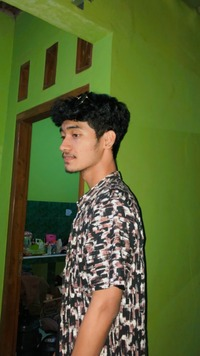

# Author :

*   Nama : Fitrah Saputra
*   Email : fitrahsaputra321@gmail.com

# Animal Classification


1.   Image classification yang dibuat pada final project ini akan mengklasifikasikan gambar antara anjing dan kucing.
2.   Pada project ini akan menggunakan model Sequential untuk pengklasifikasiannya.
3. Dataset yang digunakan pada project ini merupakan dataset dari kaggle.
4. Dataset dibagi menjadi 80% train set dan 20% test set.
5. Model menggunakan Conv2D Maxpooling Layer.
6. Menggunakan Callback.
7. Menggunakan plot terhadap akurasi dan loss model.

# 1. Setup

In [91]:
import tensorflow as tf

In [119]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [120]:
!pip install -q Kaggle
!mkdir -p ~/.kaggle               # membuat folder .kaggle di root
!mv kaggle.json ~/.kaggle         # memindahkan file kaggle.json ke folder ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json  # merubah permission file kaggle.json

In [94]:
!kaggle datasets download -d madisona/translated-animals10

translated-animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [95]:
import zipfile, os

local_zip = '/content/translated-animals10.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [96]:
import shutil
#hapus direktori

shutil.rmtree('animals10/raw-img/sheep')
shutil.rmtree('animals10/raw-img/squirrel')
shutil.rmtree('animals10/raw-img/spider')
shutil.rmtree('animals10/raw-img/chicken')
shutil.rmtree('animals10/raw-img/butterfly')
shutil.rmtree('animals10/raw-img/elephant')
shutil.rmtree('animals10/raw-img/horse')
shutil.rmtree('animals10/raw-img/cow')

In [97]:
!pip install split_folders tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
import splitfolders

splitfolders.ratio('animals10/raw-img/', output='data', seed=3, ratio=(.8, .2))

Copying files: 6531 files [00:03, 1651.19 files/s]


1.1 Load Data

In [99]:
data = '/content/data'
train_dir = os.path.join(data, 'train')
validation_dir = os.path.join(data, 'val')

# training
train_cat_dir = os.path.join(train_dir, 'cat')
train_dog_dir = os.path.join(train_dir, 'dog')

# validation
validation_cat_dir = os.path.join(validation_dir, 'cat')
validation_dog_dir = os.path.join(validation_dir, 'dog')

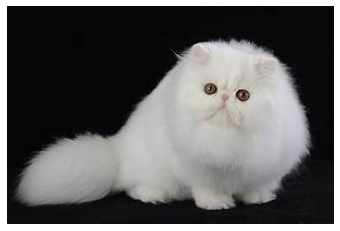

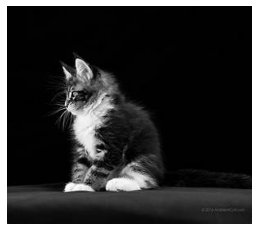

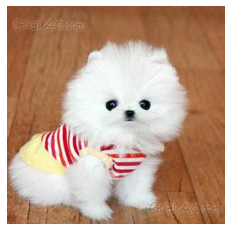

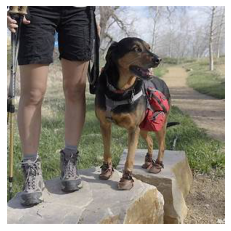

In [100]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

cat_files = os.listdir(train_cat_dir)
dog_files = os.listdir(train_dog_dir)

pic_index = random.randrange(0, 1000)

next_cat = [os.path.join(train_cat_dir, fname) 
                for fname in cat_files[pic_index-2:pic_index]]
next_dog = [os.path.join(train_dog_dir, fname) 
                for fname in dog_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_cat+next_dog):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

# 2. Prepocessing Data

2.1 Scale Data

In [101]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(                                           
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

2.2 Split Data

In [102]:
train_generator = training_datagen.flow_from_directory(                           
    train_dir, 
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = training_datagen.flow_from_directory( 
    validation_dir,
    target_size=(150, 150),
    batch_size=8, 
    class_mode='categorical'
)

Found 5224 images belonging to 2 classes.
Found 1307 images belonging to 2 classes.


# 3. Membuat Model

3.1 membuat struktur model

In [103]:
model = tf.keras.models.Sequential([                                              
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')                              
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 17, 17, 128)    

In [104]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.80 and logs.get('val_accuracy') > 0.80):
      print("\nPELATIHAN BERHENTI, AKURASI MODEL SUDAH LEBIH DARI 80%!")
      self.model.stop_training = True

callbacks = myCallback()

In [105]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

3.2 Latih Model

In [106]:
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=10,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
10/10 - 22s - loss: 0.6297 - accuracy: 0.6687 - val_loss: 0.5940 - val_accuracy: 0.7125 - 22s/epoch - 2s/step
Epoch 2/100
10/10 - 15s - loss: 0.6076 - accuracy: 0.7125 - val_loss: 0.6130 - val_accuracy: 0.7375 - 15s/epoch - 2s/step
Epoch 3/100
10/10 - 19s - loss: 0.6285 - accuracy: 0.7188 - val_loss: 0.4640 - val_accuracy: 0.8375 - 19s/epoch - 2s/step
Epoch 4/100
10/10 - 21s - loss: 0.6341 - accuracy: 0.7312 - val_loss: 0.6323 - val_accuracy: 0.7250 - 21s/epoch - 2s/step
Epoch 5/100
10/10 - 18s - loss: 0.6219 - accuracy: 0.7563 - val_loss: 0.6022 - val_accuracy: 0.7375 - 18s/epoch - 2s/step
Epoch 6/100
10/10 - 15s - loss: 0.5902 - accuracy: 0.7437 - val_loss: 0.5143 - val_accuracy: 0.8125 - 15s/epoch - 1s/step
Epoch 7/100
10/10 - 16s - loss: 0.5269 - accuracy: 0.7875 - val_loss: 0.5066 - val_accuracy: 0.8000 - 16s/epoch - 2s/step
Epoch 8/100
10/10 - 15s - loss: 0.5830 - accuracy: 0.7500 - val_loss: 0.4839 - val_accuracy: 0.8250 - 15s/epoch - 2s/step
Epoch 9/100
10/10 - 16s 

# 4. Plot Data

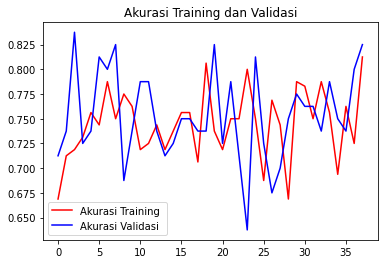

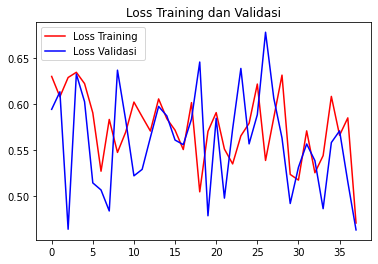

In [107]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Akurasi Training ')
plt.plot(epochs, val_acc, 'b', label = 'Akurasi Validasi')
plt.title('Akurasi Training dan Validasi')
plt.legend(loc = 0)
plt.show()

print('\n')

plt.plot(epochs, loss, 'r', label = 'Loss Training ')
plt.plot(epochs, val_loss, 'b', label = 'Loss Validasi')
plt.title('Loss Training dan Validasi')
plt.legend(loc = 0)
plt.show()

# 5. Save Model

In [121]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('animal.tflite', 'wb') as f:
  f.write(tflite_model)